# Data saving and processing

read pickle file

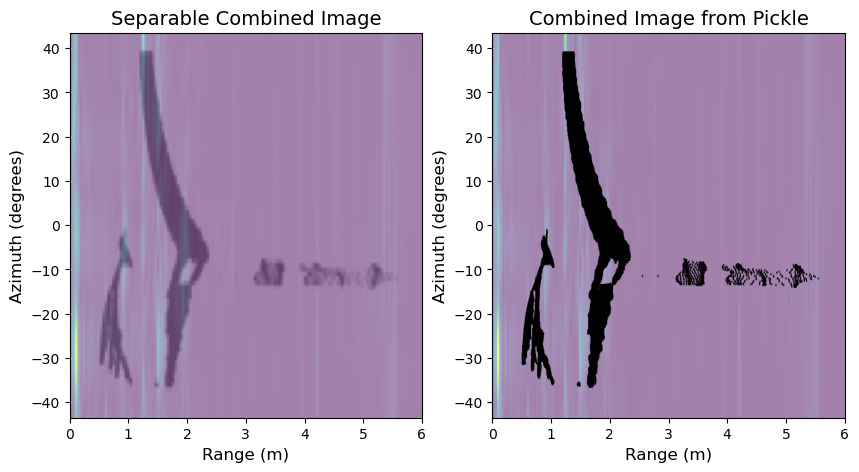

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import io

# Define depth camera configurations
depth_cam_config = {
    'd435': {
        'max_range': 3,
        'fov_azi': 69,
        'fov_ele': 42
    },
    'd455': {
        'max_range': 6,
        'fov_azi': 87,
        'fov_ele': 58
    }
}

# Select the camera type
type = 'd455'
depth_cam_config = depth_cam_config[type]

# Load the pickle file
with open('./dataset/luca_library_2024-08-12_16-18-28.pickle', 'rb') as f:
    data = pickle.load(f)

# Extract the spectrum and pointcloud data from the dictionary
processed_data = data['spectrum']
pointcloud_image_binary = data['pointcloud']
combined_image_binary = data['combination']

# Load the pointcloud image from the binary data
pointcloud_image = Image.open(io.BytesIO(pointcloud_image_binary))

# Resize the PNG image to match the shape of processed_data
pointcloud_image_resized = pointcloud_image.resize((processed_data.shape[1], processed_data.shape[0]))
pointcloud_image_resized = np.array(pointcloud_image_resized)

# Load the combined image from the binary data
combined_image = Image.open(io.BytesIO(combined_image_binary))

# Create a new figure with two subplots in a row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First subplot: Display the binarized PNG image (pointcloud) and overlay the spectrum
ax1.imshow(pointcloud_image_resized, extent=[0, depth_cam_config['max_range'], -depth_cam_config['fov_azi'] / 2, depth_cam_config['fov_azi'] / 2], aspect='auto', alpha=0.5, cmap='gray')
ax1.imshow(processed_data, extent=[0, depth_cam_config['max_range'], -depth_cam_config['fov_azi'] / 2, depth_cam_config['fov_azi'] / 2], aspect='auto', cmap='viridis', alpha=0.5)
ax1.set_xlabel("Range (m)", fontsize=12)
ax1.set_ylabel("Azimuth (degrees)", fontsize=12)
ax1.set_title("Separable Combined Image", fontsize=14)

# Second subplot: Display the combined image from the pickle file
ax2.imshow(combined_image, extent=[0, depth_cam_config['max_range'], -depth_cam_config['fov_azi'] / 2, depth_cam_config['fov_azi'] / 2], aspect='auto')
ax2.set_xlabel("Range (m)", fontsize=12)
ax2.set_ylabel("Azimuth (degrees)", fontsize=12)
ax2.set_title("Combined Image from Pickle", fontsize=14)

# Display the figure with both subplots
plt.show()


seperatable sample

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define depth camera configurations
depth_cam_config = {
    'd435': {
        'max_range': 3,
        'fov_azi': 69,
        'fov_ele': 42
    },
    'd455': {
        'max_range': 6,
        'fov_azi': 87,
        'fov_ele': 58
    }
}

# Select the camera type
type = 'd455'
depth_cam_config = depth_cam_config[type]

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the processed_data numpy array
processed_data = np.load('spectrum.npy')[0]  # Assuming this is just the array

# Load the PNG file using PIL
png_image = Image.open('pointcloud.png')

# Resize the PNG image to match the shape of processed_data
png_image_resized = png_image.resize((processed_data.shape[1], processed_data.shape[0]))
# then binarize the image
png_image_resized = np.array(png_image_resized)

# Convert the resized PNG image back to a numpy array
png_image_array = np.array(png_image_resized)

# Create a new figure and axis
fig, ax3 = plt.figure(figsize=(5, 5)), plt.subplot(111)

# Display th5 r5ized PNG image
ax3.imshow(png_image_array, extent=[0, depth_cam_config['max_range'], -depth_cam_config['fov_azi'] / 2, depth_cam_config['fov_azi'] / 2], aspect='auto', alpha=0.5)

# Overlay the processed data from the .npy file
ax3.imshow(processed_data, extent=[0, depth_cam_config['max_range'], -depth_cam_config['fov_azi'] / 2, depth_cam_config['fov_azi'] / 2],aspect='auto', alpha=0.5)
ax3.set_xlabel("Range (m)", fontsize=12)
ax3.set_ylabel("Azimuth (degrees)", fontsize=12)
ax3.set_title("Combined Image and Processed Data", fontsize=14)

# Display the combined figure
plt.show()



IndexError: tuple index out of range

In [ ]:
# show the shape of pointcloud.png
print(png_image.shape)

# mmWave Radar

https://dev.ti.com/gallery/view/mmwave/mmWaveSensingEstimator/ver/2.4.0/

## evaluation board to get the raw data

In [ ]:
import traceback
import time
from mmwave.dataloader import DCA1000
from mmwave.dataloader.radars import TI
import numpy as np
import matplotlib.pylab as plt
import datetime
import os

numframes=600

dca = None
radar = None
try:
    # del dca
    dca = DCA1000()
    # 1. reset radar and dca1000
    dca.reset_radar()
    dca.reset_fpga()
    print("wait for reset")
    time.sleep(1)
    # 2. initial para
    dca_config_file = "C:/Users/aiot/Desktop/luca_github/lss-cfar/cf.json" # lvdsMode=2
    radar_config_file = "C:/Users/aiot/Desktop/luca_github/lss-cfar/mmwave_config.cfg" # lvdsStreamCfg -1 0 1 0 (the third bit is 1), adcbufCfg -1 0 1 1 1
    # change the port number
    radar = TI(cli_loc='COM5', data_loc='COM6',data_baud=921600, config_file=radar_config_file, verbose=True)
    # stop after numframes
    radar.setFrameCfg(numframes)

    # 3. read inner chip dsp data from serial 
    radar.create_read_process(numframes)

    dca.configure(dca_config_file,radar_config_file)  # send FPGA command via Ethernet port

    # press enter to start capture
    input("press ENTER to start capture...")

    # 6. start serial reading
    radar.start_read_process()

    # 7. start via Ethernet port (DCA1000)
    dca.stream_start()

    # 8. start UDP receiving thread
    # numframes_out,sortInC_out = dca.fastRead_in_Cpp_async_start(numframes,sortInC=True) # method 1: async

    # 9. start Radar via serial 
    startTime = datetime.datetime.now()
    start = time.time()
    radar.startSensor()

    # 10. read and parse raw data
    # data_buf = dca.fastRead_in_Cpp_async_wait(numframes=numframes_out,sortInC=sortInC_out) # waiting for async thread stopping
    data_buf = dca.fastRead_in_Cpp(numframes=numframes,sortInC=True) # sync
    # data_buf = dca.read()

    end = time.time()
    print("time elapsed(s):",end-start)

    # 11. save raw data
    # filename="raw_data_"+startTime.strftime('%Y-%m-%d-%H-%M-%S')+ ".bin"
    # data_buf.tofile(filename)
    # print("file saved to",filename)

    dca.stream_stop() #automatically stop after numframe

    # 13. stop Radar
    radar.stopSensor()

    # 14. stop reading serial
    radar.stop_read_process()

    # 15. parse point cloud from serial
    DSP_Processed_data=radar.post_process_data_buf(verbose=False)
    # print(DSP_Processed_data)

    # raw data: radar.byteBuffer 
    print(radar.byteBuffer)

    # save point cloud file，load: np.load('xxx.npy', allow_pickle=True)
    # dspFileName = "DSP_data_"+startTime.strftime('%Y-%m-%d-%H-%M-%S')
    # np.save(dspFileName, DSP_Processed_data)
    # print(f'File saved to {dspFileName}.npy')

except Exception as e:
    traceback.print_exc()
finally:
    if dca is not None:
        dca.close()
    if radar is not None:
        radar.cli_port.close()
        # radar.data_port.close() # automatically 

## only mmwave radar

In [ ]:
import math
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import serial
import time
import configparser
import json
import os

def close(self):
    """End connection between radar and machine"""
    self.cli_port.write('sensorStop\n'.encode())
    self.cli_port.close()
    self.data_port.close()

def convert_size(size_bytes):
    """Convert file size to human-readable format"""
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return f"{s} {size_name[i]}"

def check_terminate_flag():
    """Check for termination signal from external file"""
    if os.path.exists(os.path.abspath(os.path.join(os.path.dirname(__file__), '../terminate_flag.txt'))):
        return True
    return False

# Configuration parameters
configFileName = 'mmwave_config.cfg'
CLIport = {}
Dataport = {}
byteBuffer = np.zeros(2**20, dtype='uint8')
byteBufferLength = 0

def serialConfig(configFileName):
    """Configure the serial ports and send configuration data to the radar"""
    global CLIport
    global Dataport
    
    CLIport = serial.Serial('COM5', 115200)
    Dataport = serial.Serial('COM6', 921600)

    config = [line.rstrip('\r\n') for line in open(configFileName)]
    for i in config:
        CLIport.write((i + '\n').encode())
        print(i)
        time.sleep(0.01)
        
    return CLIport, Dataport

def parseConfigFile(configFileName):
    """Parse configuration file to extract radar parameters"""
    configParameters = {}
    
    config = [line.rstrip('\r\n') for line in open(configFileName)]
    for i in config:
        splitWords = i.split(" ")
        numRxAnt = 4
        numTxAnt = 3
        
        if "profileCfg" in splitWords[0]:
            startFreq = int(float(splitWords[2]))
            idleTime = int(splitWords[3])
            rampEndTime = float(splitWords[5])
            freqSlopeConst = float(splitWords[8])
            numAdcSamples = int(splitWords[10])
            numAdcSamplesRoundTo2 = 1
            
            while numAdcSamples > numAdcSamplesRoundTo2:
                numAdcSamplesRoundTo2 = numAdcSamplesRoundTo2 * 2
                
            digOutSampleRate = int(splitWords[11])
        
        elif "frameCfg" in splitWords[0]:
            chirpStartIdx = int(splitWords[1])
            chirpEndIdx = int(splitWords[2])
            numLoops = int(splitWords[3])
            numFrames = int(splitWords[4])
            framePeriodicity = float(splitWords[5])
            
    numChirpsPerFrame = (chirpEndIdx - chirpStartIdx + 1) * numLoops
    configParameters["numDopplerBins"] = numChirpsPerFrame / numTxAnt
    configParameters["numRangeBins"] = numAdcSamplesRoundTo2
    configParameters["rangeResolutionMeters"] = (3e8 * digOutSampleRate * 1e3) / (2 * freqSlopeConst * 1e12 * numAdcSamples)
    configParameters["rangeIdxToMeters"] = (3e8 * digOutSampleRate * 1e3) / (2 * freqSlopeConst * 1e12 * configParameters["numRangeBins"])
    configParameters["dopplerResolutionMps"] = 3e8 / (2 * startFreq * 1e9 * (idleTime + rampEndTime) * 1e-6 * configParameters["numDopplerBins"] * numTxAnt)
    configParameters["maxRange"] = (300 * 0.9 * digOutSampleRate) / (2 * freqSlopeConst * 1e3)
    configParameters["maxVelocity"] = 3e8 / (4 * startFreq * 1e9 * (idleTime + rampEndTime) * 1e-6 * numTxAnt)
    
    return configParameters

def readAndParseData18xx(Dataport, configParameters):
    """Read and parse incoming data from the radar"""
    global byteBuffer, byteBufferLength
    
    OBJ_STRUCT_SIZE_BYTES = 12
    BYTE_VEC_ACC_MAX_SIZE = 2**15
    MMWDEMO_UART_MSG_DETECTED_POINTS = 1
    MMWDEMO_UART_MSG_RANGE_PROFILE = 2
    maxBufferSize = 2**15
    tlvHeaderLengthInBytes = 8
    pointLengthInBytes = 16
    magicWord = [2, 1, 4, 3, 6, 5, 8, 7]
    
    magicOK = 0
    dataOK = 0
    frameNumber = 0
    detObj = {}
    
    readBuffer = Dataport.read(Dataport.in_waiting)
    byteVec = np.frombuffer(readBuffer, dtype='uint8')
    byteCount = len(byteVec)
    
    if (byteBufferLength + byteCount) < maxBufferSize:
        byteBuffer[byteBufferLength:byteBufferLength + byteCount] = byteVec[:byteCount]
        byteBufferLength = byteBufferLength + byteCount
        
    if byteBufferLength > 16:
        possibleLocs = np.where(byteBuffer == magicWord[0])[0]
        startIdx = []
        for loc in possibleLocs:
            check = byteBuffer[loc:loc+8]
            if np.all(check == magicWord):
                startIdx.append(loc)
               
        if startIdx:
            if startIdx[0] > 0 and startIdx[0] < byteBufferLength:
                byteBuffer[:byteBufferLength-startIdx[0]] = byteBuffer[startIdx[0]:byteBufferLength]
                byteBuffer[byteBufferLength-startIdx[0]:] = np.zeros(len(byteBuffer[byteBufferLength-startIdx[0]:]), dtype='uint8')
                byteBufferLength = byteBufferLength - startIdx[0]
                
            if byteBufferLength < 0:
                byteBufferLength = 0
                
            word = [1, 2**8, 2**16, 2**24]
            totalPacketLen = np.matmul(byteBuffer[12:12+4], word)
            
            if (byteBufferLength >= totalPacketLen) and (byteBufferLength != 0):
                magicOK = 1
    
    if magicOK:
        word = [1, 2**8, 2**16, 2**24]
        idX = 0
        
        magicNumber = byteBuffer[idX:idX+8]
        idX += 8
        version = format(np.matmul(byteBuffer[idX:idX+4], word), 'x')
        idX += 4
        totalPacketLen = np.matmul(byteBuffer[idX:idX+4], word)
        idX += 4
        platform = format(np.matmul(byteBuffer[idX:idX+4], word), 'x')
        idX += 4
        frameNumber = np.matmul(byteBuffer[idX:idX+4], word)
        idX += 4
        timeCpuCycles = np.matmul(byteBuffer[idX:idX+4], word)
        idX += 4
        numDetectedObj = np.matmul(byteBuffer[idX:idX+4], word)
        idX += 4
        numTLVs = np.matmul(byteBuffer[idX:idX+4], word)
        idX += 4
        subFrameNumber = np.matmul(byteBuffer[idX:idX+4], word)
        idX += 4

        for tlvIdx in range(numTLVs):
            word = [1, 2**8, 2**16, 2**24]
            tlv_type = np.matmul(byteBuffer[idX:idX+4], word)
            idX += 4
            tlv_length = np.matmul(byteBuffer[idX:idX+4], word)
            idX += 4

            if tlv_type == MMWDEMO_UART_MSG_DETECTED_POINTS:
                x = np.zeros(numDetectedObj, dtype=np.float32)
                y = np.zeros(numDetectedObj, dtype=np.float32)
                z = np.zeros(numDetectedObj, dtype=np.float32)
                velocity = np.zeros(numDetectedObj, dtype=np.float32)
                
                for objectNum in range(numDetectedObj):
                    x[objectNum] = byteBuffer[idX:idX + 4].view(dtype=np.float32)
                    idX += 4
                    y[objectNum] = byteBuffer[idX:idX + 4].view(dtype=np.float32)
                    idX += 4
                    z[objectNum] = byteBuffer[idX:idX + 4].view(dtype=np.float32)
                    idX += 4
                    velocity[objectNum] = byteBuffer[idX:idX + 4].view(dtype=np.float32)
                    idX += 4
                
                detObj = {"numObj": numDetectedObj, "x": x, "y": y, "z": z, "velocity": velocity}
                dataOK = 1
                
        if idX > 0 and byteBufferLength > idX:
            shiftSize = totalPacketLen
            byteBuffer[:byteBufferLength - shiftSize] = byteBuffer[shiftSize:byteBufferLength]
            byteBuffer[byteBufferLength - shiftSize:] = np.zeros(len(byteBuffer[byteBufferLength - shiftSize:]), dtype='uint8')
            byteBufferLength = byteBufferLength - shiftSize
            
            if byteBufferLength < 0:
                byteBufferLength = 0         

    return dataOK, frameNumber, detObj

def update():
    """Update the data and display in the plot"""
    dataOk = 0
    global detObj
    global scatter_plot_collection 
    x = []
    y = []
      
    dataOk, frameNumber, detObj = readAndParseData18xx(Dataport, configParameters)
    
    if dataOk and len(detObj["x"]) > 0:
        x = -detObj["x"]
        y = detObj["y"]
        
        if scatter_plot_collection:
            scatter_plot_collection.remove()

        scatter_plot_collection = ax.scatter(x, y, detObj["z"], c='r', marker='o')
        plt.draw()
        plt.pause(0.1)
        # QtWidgets.QApplication.processEvents()
    
    return dataOk

# Main execution
CLIport, Dataport = serialConfig(configFileName)
configParameters = parseConfigFile(configFileName)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.set_xlim(-5, 5)
ax.set_ylim(0, 3)
ax.set_zlim(-5, 5)
scatter_plot_collection = ax.scatter([], [], [], c='r', marker='o')

detObj = {}  
frameData = {}    
currentIndex = 0

while True:
    try:
        dataOk = update()
        if check_terminate_flag():
            CLIport.write(('sensorStop\n').encode())
            CLIport.close()
            Dataport.close()
            break
        time.sleep(0.001)
        
    except KeyboardInterrupt:
        CLIport.write(('sensorStop\n').encode())
        CLIport.close()
        Dataport.close()
        plt.close()
        break


config.cfg file

% ***************************************************************
% Created for SDK ver:03.06
% Created using Visualizer ver:3.6.0.0
% Frequency:77
% Platform:xWR18xx
% Scene Classifier:best_range_res
% Azimuth Resolution(deg):15 + Elevation
% Range Resolution(m):0.044
% Maximum unambiguous Range(m):9.02
% Maximum Radial Velocity(m/s):1
% Radial velocity resolution(m/s):0.13
% Frame Duration(msec):10
% RF calibration data:None
% Range Detection Threshold (dB):15
% Doppler Detection Threshold (dB):15
% Range Peak Grouping:enabled
% Doppler Peak Grouping:enabled
% Static clutter removal:disabled
% Angle of Arrival FoV: Full FoV
% Range FoV: Full FoV
% Doppler FoV: Full FoV
% ***************************************************************
sensorStop
flushCfg
dfeDataOutputMode 1
channelCfg 15 7 0
adcCfg 2 1
adcbufCfg -1 0 1 1 1
profileCfg 0 77 267 7 57.14 0 0 70 1 256 5209 0 0 30
chirpCfg 0 0 0 0 0 0 0 1
chirpCfg 1 1 0 0 0 0 0 4
chirpCfg 2 2 0 0 0 0 0 2
frameCfg 0 2 16 0 100 1 0
lowPower 0 0
guiMonitor -1 1 1 0 0 0 1
cfarCfg -1 0 2 8 4 3 0 15 1
cfarCfg -1 1 0 4 2 3 1 15 1
multiObjBeamForming -1 1 0.5
clutterRemoval -1 0
calibDcRangeSig -1 0 -5 8 256
extendedMaxVelocity -1 0
lvdsStreamCfg -1 0 0 0
compRangeBiasAndRxChanPhase 0.0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
measureRangeBiasAndRxChanPhase 0 1.5 0.2
CQRxSatMonitor 0 3 5 121 0
CQSigImgMonitor 0 127 4
analogMonitor 0 0
aoaFovCfg -1 -90 90 -90 90
cfarFovCfg -1 0 0 8.92
cfarFovCfg -1 1 -1 1.00
calibData 0 0 0
sensorStart

# Depth Camera
D435, datasheet: https://store.intelrealsense.com/buy-intel-realsense-depth-camera-d435.html#


D355, dataseheet: https://store.intelrealsense.com/buy-intel-realsense-depth-camera-d455.html

## only pointcloud 3d

In [ ]:
import math
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class AppState:
    def __init__(self):
        self.paused = False
        self.decimate = 0

state = AppState()

# Configure streams
pipeline = rs.pipeline()
config = rs.config()

pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
profile = pipeline.start(config)

# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)

# Create an align object
# rs.align allows us to perform alignment of depth frames to others frames
# The "align_to" is the stream type to which we plan to align depth frames.
align_to = rs.stream.color
align = rs.align(align_to)

# Processing blocks
pc = rs.pointcloud()
decimate = rs.decimation_filter()
decimate.set_option(rs.option.filter_magnitude, 2 ** state.decimate)

def get_point_cloud(aligned_depth_frame):
    depth_frame = decimate.process(aligned_depth_frame)
    points = pc.calculate(depth_frame)
    verts = np.asarray(points.get_vertices()).view(np.float32).reshape(-1, 3)
    return verts

try:
    plt.ion()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("3D Point Cloud")

    while True:
        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)

        aligned_depth_frame = aligned_frames.get_depth_frame()
        color_frame = aligned_frames.get_color_frame()

        if not aligned_depth_frame or not color_frame:
            continue

        verts = get_point_cloud(aligned_depth_frame)

        # Clear the 3D plot and plot the new point cloud
        ax.cla()
        ax.set_title("3D Point Cloud")
        ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], c=verts[:, 2], cmap='jet', s=1)

        plt.draw()
        plt.pause(0.1)

finally:
    pipeline.stop()
    plt.ioff()
    plt.show()


## pointcloud3d


In [ ]:
import math
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

class AppState:
    def __init__(self):
        self.paused = False
        self.decimate = 0

state = AppState()

# Configure streams
pipeline = rs.pipeline()
config = rs.config()

pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
profile = pipeline.start(config)

# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)

# Create an align object
# rs.align allows us to perform alignment of depth frames to others frames
# The "align_to" is the stream type to which we plan to align depth frames.
align_to = rs.stream.color
align = rs.align(align_to)

# Processing blocks
pc = rs.pointcloud()
decimate = rs.decimation_filter()
decimate.set_option(rs.option.filter_magnitude, 2 ** state.decimate)

def get_point_cloud(aligned_depth_frame):
    depth_frame = decimate.process(aligned_depth_frame)
    points = pc.calculate(depth_frame)
    verts = np.asarray(points.get_vertices()).view(np.float32).reshape(-1, 3)
    return verts

try:
    plt.ion()
    fig = plt.figure(figsize=(15, 5))

    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    ax1.set_title("3D Point Cloud")
    ax2.set_title("RGB Image")
    ax3.set_title("Depth Colormap")

    while True:
        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)

        aligned_depth_frame = aligned_frames.get_depth_frame()
        color_frame = aligned_frames.get_color_frame()

        if not aligned_depth_frame or not color_frame:
            continue

        depth_image = np.asanyarray(aligned_depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        # Render images:
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

        # Update RGB image
        ax2.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
        ax2.axis('off')

        # Update Depth colormap
        ax3.imshow(cv2.cvtColor(depth_colormap, cv2.COLOR_BGR2RGB))
        ax3.axis('off')

        verts = get_point_cloud(aligned_depth_frame)

        # Clear the 3D plot and plot the new point cloud
        ax1.cla()
        ax1.set_title("3D Point Cloud")
        ax1.scatter(verts[:, 0], verts[:, 1], verts[:, 2], c=verts[:, 2], cmap='jet', s=1)

        plt.draw()
        plt.pause(0.1)

finally:
    pipeline.stop()
    plt.ioff()
    plt.show()


In [ ]:
import math
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class AppState:
    def __init__(self):
        self.paused = False
        self.decimate = 0

state = AppState()

# Configure streams
pipeline = rs.pipeline()
config = rs.config()

pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)

config.enable_stream(rs.stream.depth, rs.format.z16, 30)
pipeline.start(config)
profile = pipeline.get_active_profile()

depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.depth))
depth_intrinsics = depth_profile.get_intrinsics()
w, h = depth_intrinsics.width, depth_intrinsics.height

# Processing blocks
pc = rs.pointcloud()
decimate = rs.decimation_filter()
decimate.set_option(rs.option.filter_magnitude, 2 ** state.decimate)

def get_point_cloud():
    frames = pipeline.wait_for_frames()
    depth_frame = frames.get_depth_frame()

    depth_frame = decimate.process(depth_frame)

    # Calculate the point cloud
    points = pc.calculate(depth_frame)
    verts = np.asarray(points.get_vertices()).view(np.float32).reshape(-1, 3)

    return verts

# Start streaming
try:
    plt.ion()
    fig = plt.figure(figsize=(12, 6))

    # Create subplots
    ax2d = fig.add_subplot(121)
    ax3d = fig.add_subplot(122, projection='3d')

    # Set fixed axis limits for the 2D plot
    ax2d.set_xlim(-1, 1)  # Adjust these values as necessary
    ax2d.set_ylim(1, -1)  # Reverse the Y-axis

    scatter2d = ax2d.scatter([], [], s=1, c='black')

    while True:
        verts = get_point_cloud()

        # Extract X, Y, and Z coordinates
        x = verts[:, 0]
        y = verts[:, 1]
        z = verts[:, 2]

        # Update 2D scatter plot
        scatter2d.set_offsets(np.c_[x, y])
        ax2d.set_title("Point Cloud in X-Y Plane")
        ax2d.set_xlabel("X")
        ax2d.set_ylabel("Y")
        ax2d.axis('equal')

        # Update 3D scatter plot
        ax3d.cla()
        ax3d.scatter(x, y, z, s=1, c='black')
        ax3d.set_title("3D Point Cloud")
        ax3d.set_xlabel("X")
        ax3d.set_ylabel("Y")
        ax3d.set_zlabel("Z")

        plt.draw()
        plt.pause(0.1)

finally:
    pipeline.stop()


## pointcloud 2d

In [ ]:
import math
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt

class AppState:
    def __init__(self):
        self.paused = False
        self.decimate = 0

state = AppState()

# Configure streams
pipeline = rs.pipeline()
config = rs.config()

pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)

config.enable_stream(rs.stream.depth, rs.format.z16, 30)
pipeline.start(config)
profile = pipeline.get_active_profile()

depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.depth))
depth_intrinsics = depth_profile.get_intrinsics()
w, h = depth_intrinsics.width, depth_intrinsics.height

# Processing blocks
pc = rs.pointcloud()
decimate = rs.decimation_filter()
decimate.set_option(rs.option.filter_magnitude, 2 ** state.decimate)

def get_point_cloud():
    frames = pipeline.wait_for_frames()
    depth_frame = frames.get_depth_frame()

    depth_frame = decimate.process(depth_frame)

    # Calculate the point cloud
    points = pc.calculate(depth_frame)
    verts = np.asarray(points.get_vertices()).view(np.float32).reshape(-1, 3)

    return verts

# Start streaming
try:
    plt.ion()
    fig, ax = plt.subplots(figsize=(10, 10))

    # Set fixed axis limits based on the expected range of the point cloud data
    ax.set_xlim(-1, 1)  # Adjust these values as necessary
    ax.set_ylim(1, -1)  # Reverse the Y-axis

    scatter = ax.scatter([], [], s=1, c='black')

    while True:
        verts = get_point_cloud()

        # Extract X and Y coordinates
        x = verts[:, 0]
        y = verts[:, 1]

        scatter.set_offsets(np.c_[x, y])
        ax.set_title("Point Cloud in X-Y Plane")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.axis('equal')

        plt.draw()
        plt.pause(0.1)

finally:
    pipeline.stop()


## pintcloud 2d+3d

## aligned sample

In [ ]:
## License: Apache 2.0. See LICENSE file in root directory.
## Copyright(c) 2017 Intel Corporation. All Rights Reserved.

#####################################################
##              Align Depth to Color               ##
#####################################################

# First import the library
import pyrealsense2 as rs
# Import Numpy for easy array manipulation
import numpy as np
# Import OpenCV for easy image rendering
import cv2

# Create a pipeline
pipeline = rs.pipeline()

# Create a config and configure the pipeline to stream
#  different resolutions of color and depth streams
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
profile = pipeline.start(config)

# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)

# We will be removing the background of objects more than
#  clipping_distance_in_meters meters away
clipping_distance_in_meters = 1 #1 meter
clipping_distance = clipping_distance_in_meters / depth_scale

# Create an align object
# rs.align allows us to perform alignment of depth frames to others frames
# The "align_to" is the stream type to which we plan to align depth frames.
align_to = rs.stream.color
align = rs.align(align_to)

# Streaming loop
try:
    while True:
        # Get frameset of color and depth
        frames = pipeline.wait_for_frames()
        # frames.get_depth_frame() is a 640x360 depth image

        # Align the depth frame to color frame
        aligned_frames = align.process(frames)

        # Get aligned frames
        aligned_depth_frame = aligned_frames.get_depth_frame() # aligned_depth_frame is a 640x480 depth image
        color_frame = aligned_frames.get_color_frame()

        # Validate that both frames are valid
        if not aligned_depth_frame or not color_frame:
            continue

        depth_image = np.asanyarray(aligned_depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        # Remove background - Set pixels further than clipping_distance to grey
        grey_color = 153
        depth_image_3d = np.dstack((depth_image,depth_image,depth_image)) #depth image is 1 channel, color is 3 channels
        bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), grey_color, color_image)

        # Render images:
        #   depth align to color on left
        #   depth on right
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
        images = np.hstack((bg_removed, depth_colormap))

        cv2.namedWindow('Align Example', cv2.WINDOW_NORMAL)
        cv2.imshow('Align Example', images)
        key = cv2.waitKey(1)
        # Press esc or 'q' to close the image window
        if key & 0xFF == ord('q') or key == 27:
            cv2.destroyAllWindows()
            break
finally:
    pipeline.stop()

## pointcloud sample

In [ ]:
## License: Apache 2.0. See LICENSE file in root directory.
## Copyright(c) 2017 Intel Corporation. All Rights Reserved.

#####################################################
##                  Export to PLY                  ##
#####################################################

# First import the library
import pyrealsense2 as rs


# Declare pointcloud object, for calculating pointclouds and texture mappings
pc = rs.pointcloud()
# We want the points object to be persistent so we can display the last cloud when a frame drops
points = rs.points()

# Declare RealSense pipeline, encapsulating the actual device and sensors
pipe = rs.pipeline()
config = rs.config()
# Enable depth stream
config.enable_stream(rs.stream.depth)

# Start streaming with chosen configuration
pipe.start(config)

# We'll use the colorizer to generate texture for our PLY
# (alternatively, texture can be obtained from color or infrared stream)
colorizer = rs.colorizer()

try:
    # Wait for the next set of frames from the camera
    frames = pipe.wait_for_frames()
    colorized = colorizer.process(frames)

    # Create save_to_ply object
    ply = rs.save_to_ply("1.ply")

    # Set options to the desired values
    # In this example we'll generate a textual PLY with normals (mesh is already created by default)
    ply.set_option(rs.save_to_ply.option_ply_binary, False)
    ply.set_option(rs.save_to_ply.option_ply_normals, True)

    print("Saving to 1.ply...")
    # Apply the processing block to the frameset which contains the depth frame and the texture
    ply.process(colorized)
    print("Done")
finally:
    pipe.stop()